### BitcoinBot

Réalisé par:
* Amine SNOUSSI
* Mohammed JAWHAR

###  ⏳ <font color = 'blue'> Aperçu</font>
This project aims to implement a trading Bot that performs the BTC/MAD conversion and provides recommendations to the user to achieve maximum gain during a given period.

In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import chatterbot
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

### 📂 <font color = 'blue'> Dataset </font>

The dataset contains the historical price information of some of the top crypto currencies by market capitalization.

#### <font color = 'black'> Load the dataset and quick preview</font>

In [2]:
df = pd.read_csv("coin_Bitcoin.csv")

In [3]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [4]:
#Data types
print(f"Les types de données dans notre dataset sont:\n{df.dtypes}\n")

Les types de données dans notre dataset sont:
SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object



In [5]:
#Empty cells
print(f"Le nombre de cellule vides dans notre dataset est :\n{df.isna().sum()}")

Le nombre de cellule vides dans notre dataset est :
SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64


It's time to clean the data, we drop the columns with less value,then we transform the Date column to conserve just the date (from this format "YYYY-MM-dd HH:mm:ss" to "YYYY-MM-dd")

In [6]:
df = df.drop(['SNo', 'Name','Symbol'], axis=1)
df['Date'] = df['Date'].apply(lambda x: x.split()[0])

We set the Date column as the index of our Dataframe 

In [7]:
df = df.set_index('Date', drop=True)

In [8]:
#We keep just the data after 01/01/2014 to avoid 0 values in Volume column  
df=df[df.index>='2014-01-01']

In [9]:
df.head()

,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2014-01-01,775.349976,754.969971,754.969971,771.400024,22489400.0,9.403308e+09
2014-01-02,820.309998,767.210022,773.440002,802.390015,38489500.0,9.781074e+09
2014-01-03,834.150024,789.119995,802.849976,818.719971,37810100.0,9.980135e+09
2014-01-04,859.510010,801.669983,823.270020,859.510010,38005000.0,1.047736e+10
2014-01-05,952.400024,854.520020,858.549988,933.530029,72898496.0,1.137966e+10


In [10]:
df.describe()

,High,Low,Open,Close,Volume,Marketcap
count,2744.000000,2744.000000,2744.000000,2744.000000,2.744000e+03,2.744000e+03
mean,7489.534333,7048.233568,7280.246366,7292.183039,1.188801e+10,1.314806e+11
std,11976.993187,11177.611238,11610.796734,11621.015546,1.942284e+10,2.171195e+11
min,211.731003,171.509995,176.897003,178.102997,2.857830e+06,2.444379e+09
25%,504.874001,482.110764,492.291260,491.788757,4.922518e+07,6.939725e+09
50%,3777.341713,3623.317190,3673.608484,3678.744329,2.260650e+09,6.427960e+10
75%,9167.717183,8757.263976,8915.889013,8912.858386,1.758296e+10,1.589677e+11
max,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2744 entries, 2014-01-01 to 2021-07-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2744 non-null   float64
 1   Low        2744 non-null   float64
 2   Open       2744 non-null   float64
 3   Close      2744 non-null   float64
 4   Volume     2744 non-null   float64
 5   Marketcap  2744 non-null   float64
dtypes: float64(6)
memory usage: 150.1+ KB


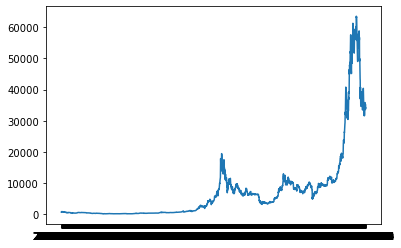

In [12]:
#Plotting the price of Bitcoin 
plt.plot(df.index,df['Close'])
plt.show()

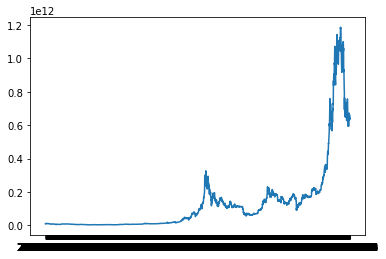

In [13]:
#Plotting the market capitalisation
plt.plot(df['Marketcap'])
plt.show()

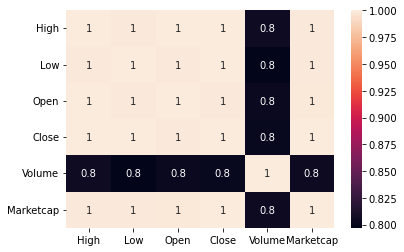

In [14]:
#Plotting the correlation matrix to select the appropriate columns
mat = df.corr()
sb.heatmap(mat,annot=True)
plt.show()

In [15]:
#The function bellow split the data in two sections(80% : train data ain 20% : test data)
def train_test_split(df,test_size):
    n=len(df)
    split_row = n - int(test_size*n)
    train = df.iloc[:split_row]
    test = df.iloc[split_row:]
    return train, test

#### <font color = 'blue'> Linear Regression</font>

We will try to implement a lnear regression model and train it to make predictions and test the model

In [16]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression()

In [17]:
X=df[['Open','Volume']]  #explanatory variables
Y=df['Close'] #target variable

In [18]:
#we split both explanotary and target variables into train section and test section
xtrain, xtest = train_test_split(X,0.2)
ytrain, ytest = train_test_split(Y,0.2)

In [19]:
print(xtrain.shape, xtest.shape)
ytrain.shape, ytest.shape

(2196, 2) (548, 2)


((2196,), (548,))

In [20]:
#Training the model
reg.fit(xtrain,ytrain)

LinearRegression()

In [21]:
#Testing the model
ypred=reg.predict(xtest)

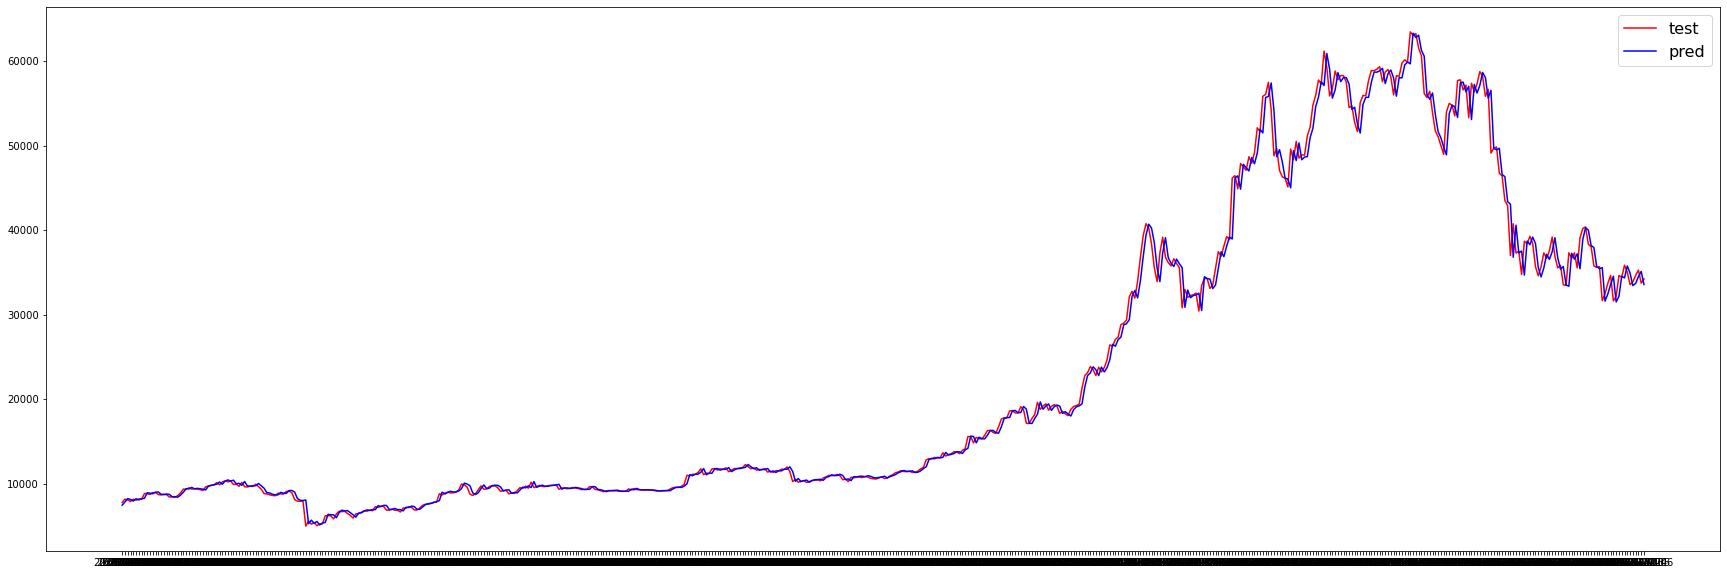

In [22]:
#Plotting the real prices and predicted ones 
plt.figure(figsize=(30,10))
plt.plot(ytest,label='test',color='red')
plt.plot(ypred,label='pred',color='blue')
plt.legend(loc='best', fontsize=16)
plt.show()

In [23]:
#Comparing the real prices with predicted ones 
print(pd.DataFrame({'real_value':ytest,'pred_value':ypred}))

              real_value    pred_value
Date                                  
2020-01-06   7769.219039   7451.907660
2020-01-07   8163.692239   7827.042092
2020-01-08   8079.862777   8227.767666
2020-01-09   7879.071524   8121.628992
2020-01-10   8166.554140   7935.688401
...                  ...           ...
2021-07-02  33897.048590  33457.016111
2021-07-03  34668.548402  33708.708767
2021-07-04  35287.779766  34515.908720
2021-07-05  33746.002456  35136.596937
2021-07-06  34235.193451  33586.259661

[548 rows x 2 columns]


As we can see, our model is pretty good and it has high accuracy: 

In [24]:
rsquared_adj = 1 - (1-reg.score(X, Y))*(Y.shape[0]-1)/(Y.shape[0]-X.shape[1]-1)
print(rsquared_adj)

0.9971937112656122


In [25]:
#A small preview of splitting the data
train, test = train_test_split(df,0.2)

In [26]:
train.shape, test.shape

((2196, 6), (548, 6))

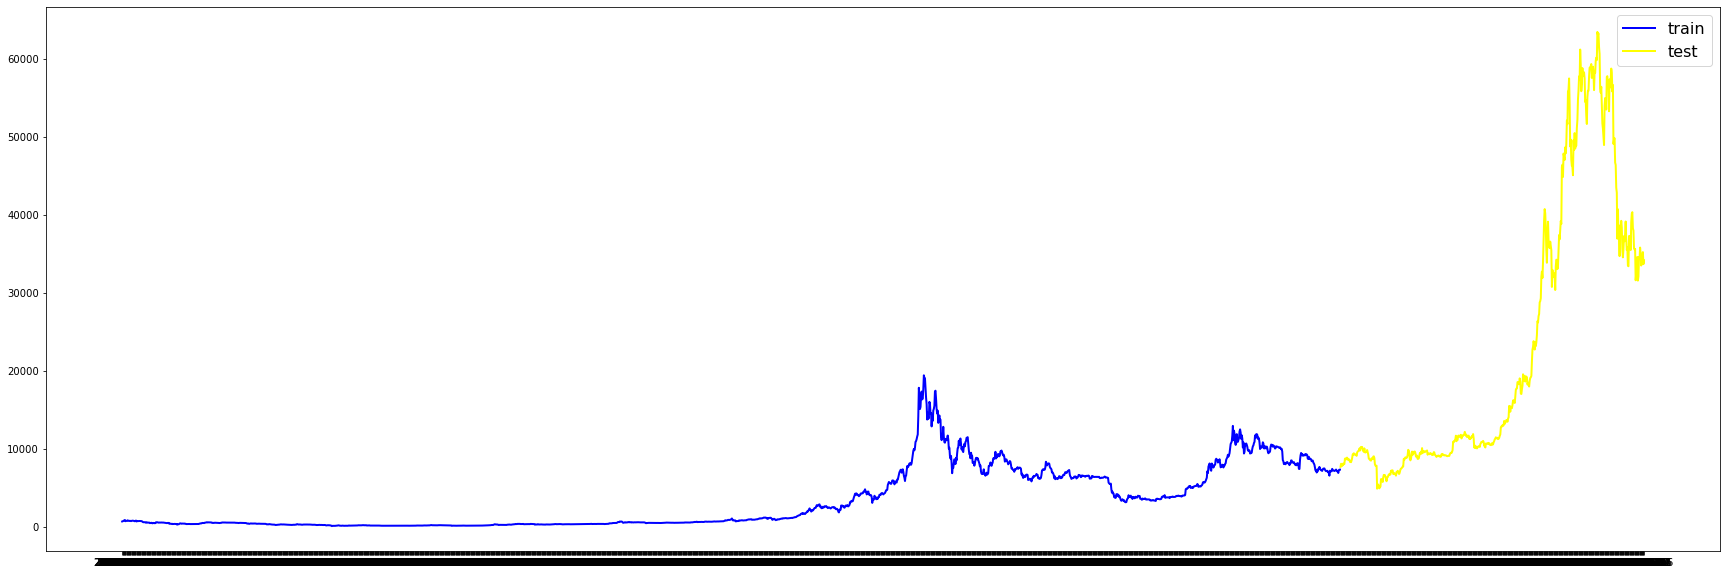

In [27]:
plt.figure(figsize=(30, 10))
plt.plot(train['Close'],label='train',linewidth=2,color='blue')
plt.plot(test['Close'],label='test',linewidth=2,color='yellow')
plt.legend(loc='best', fontsize=16)
plt.show()

#### <font color = 'blue'> LSTM</font>

It's time to apply some normalisation techniques: Normalization is a data preparation technique that is frequently used in machine learning. It is the process of converting the values of numeric columns in a dataset to a similar scale without distorting the ranges of values.

In [28]:
def normalise_zero_base(df):
    return df/df.iloc[0] - 1

def normalise_min_max(df):
    return (df-df.min()) / (data.max()-df.min())

After applying the linear regression model to our data , we will try to implement a deep learning model: LSTM which is very suitable to this case 

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture[1] used in the field of deep learning.
It works by allowing each LSTM layer to take information from both previous and current layers using specific gates. The data is sent via the LSTM cells after passing through many gates (such as the forget gate, input gate, and so on) and various activation functions (such as the tanh function, relu function). The key benefit of this is that each LSTM cell can recall patterns for a set amount of time. It's worth noting that LSTM can remember crucial information while forgetting irrelevant information.

In [29]:
def extract_window_data(df,m, zero_base=True):
    n=len(df)
    window = []
    for i in range(n-m):
        tmp = df[i: (i + m)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window.append(tmp.values)
    return np.array(window)

In [30]:
def prepare_data(df,target_col,m,zero_base,ts):
    """ Prepare data for LSTM. """
    # train test split
    train, test = train_test_split(df,ts)
    
    # extract window data
    xtrain = extract_window_data(train,m,zero_base)
    xtest = extract_window_data(test,m,zero_base)
    
    # extract targets
    ytrain = train[target_col][m:].values
    ytest = test[target_col][m:].values
    if zero_base:
        ytrain = ytrain / train[target_col][:-m].values - 1
        ytest = ytest / test[target_col][:-m].values - 1

    return train, test, xtrain, xtest, ytrain, ytest

In [31]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [32]:
np.random.seed(42)

# data parameters
target_col='Close'
m = 10
ts = 0.2
zero_base = True

# model parameters
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [33]:
train, test, xtrain, xtest, ytrain, ytest = prepare_data(df, target_col, m, zero_base, ts)

In [34]:
#Building and training th model
model = build_lstm_model(xtrain, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(xtrain, ytrain, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
547/547 [==============================] - 4s 4ms/step - loss: 0.0509
Epoch 2/50
547/547 [==============================] - 3s 5ms/step - loss: 0.0383
Epoch 3/50
547/547 [==============================] - 3s 5ms/step - loss: 0.0348
Epoch 4/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0326
Epoch 5/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0316
Epoch 6/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0311
Epoch 7/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0308
Epoch 8/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0298
Epoch 9/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0297
Epoch 10/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0294
Epoch 11/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0289
Epoch 12/50
547/547 [==============================] - 3s 5ms/step - loss: 0.0287
Epoch 13/50
547/547 [====

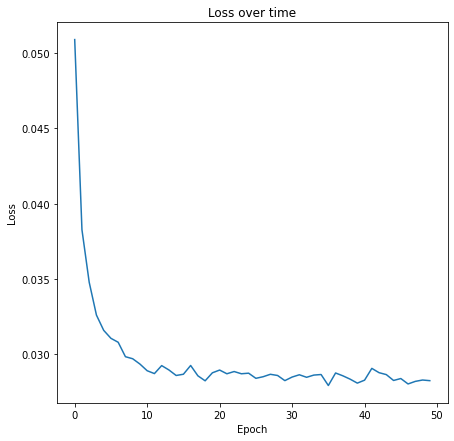

In [35]:
plt.figure(figsize=(7,7));
plt.title("Loss over time");
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.plot(history.history['loss']);

In [36]:
#Testing the model
targets = test['Close'][m:]
preds = model.predict(xtest).squeeze()

In [37]:
#Calculating the mean absolute error 
mean_absolute_error(preds, ytest)

0.02838856353904627

In [38]:
preds = test[target_col].values[:-m] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

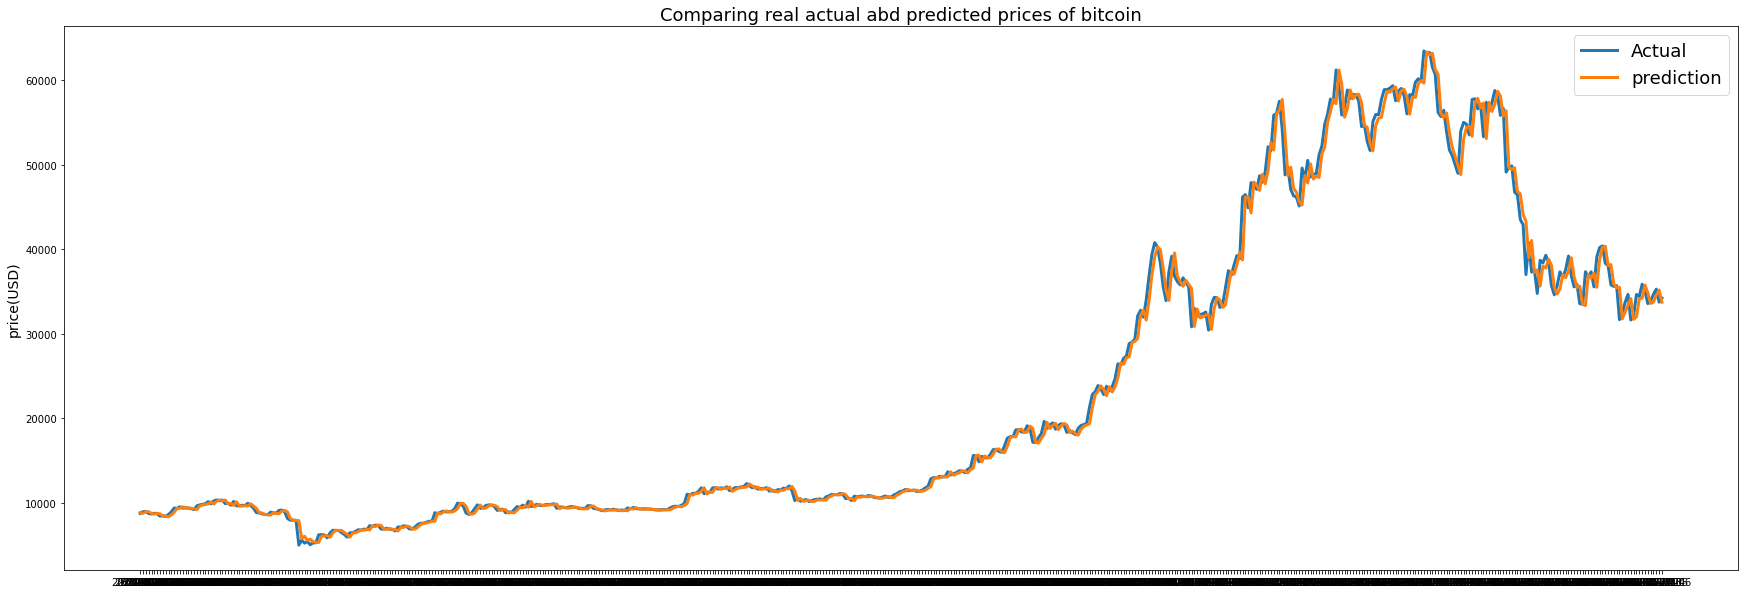

In [39]:
fig, ax = plt.subplots(1, figsize=(30,10))
ax.plot(targets, label='Actual', linewidth=3)
ax.plot(preds, label='prediction', linewidth=3)
ax.set_ylabel('price(USD)', fontsize=14)
ax.set_title("Comparing real actual abd predicted prices of bitcoin", fontsize=18)
ax.legend(loc='best', fontsize=18);


In [40]:
#Comparing real prices with predicted ones
print(pd.DataFrame({'real_value':targets,'pred_value':preds}))

              real_value    pred_value
Date                                  
2020-01-16   8723.785766   8815.660142
2020-01-17   8929.037678   8727.666336
2020-01-18   8942.808903   8911.089209
2020-01-19   8706.245130   8932.106184
2020-01-20   8657.642939   8724.538195
...                  ...           ...
2021-07-02  33897.048590  33583.290821
2021-07-03  34668.548402  33761.183731
2021-07-04  35287.779766  34550.299388
2021-07-05  33746.002456  35174.980513
2021-07-06  34235.193451  33741.132851

[538 rows x 2 columns]


In [41]:
#Calculating real and predicted returns
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

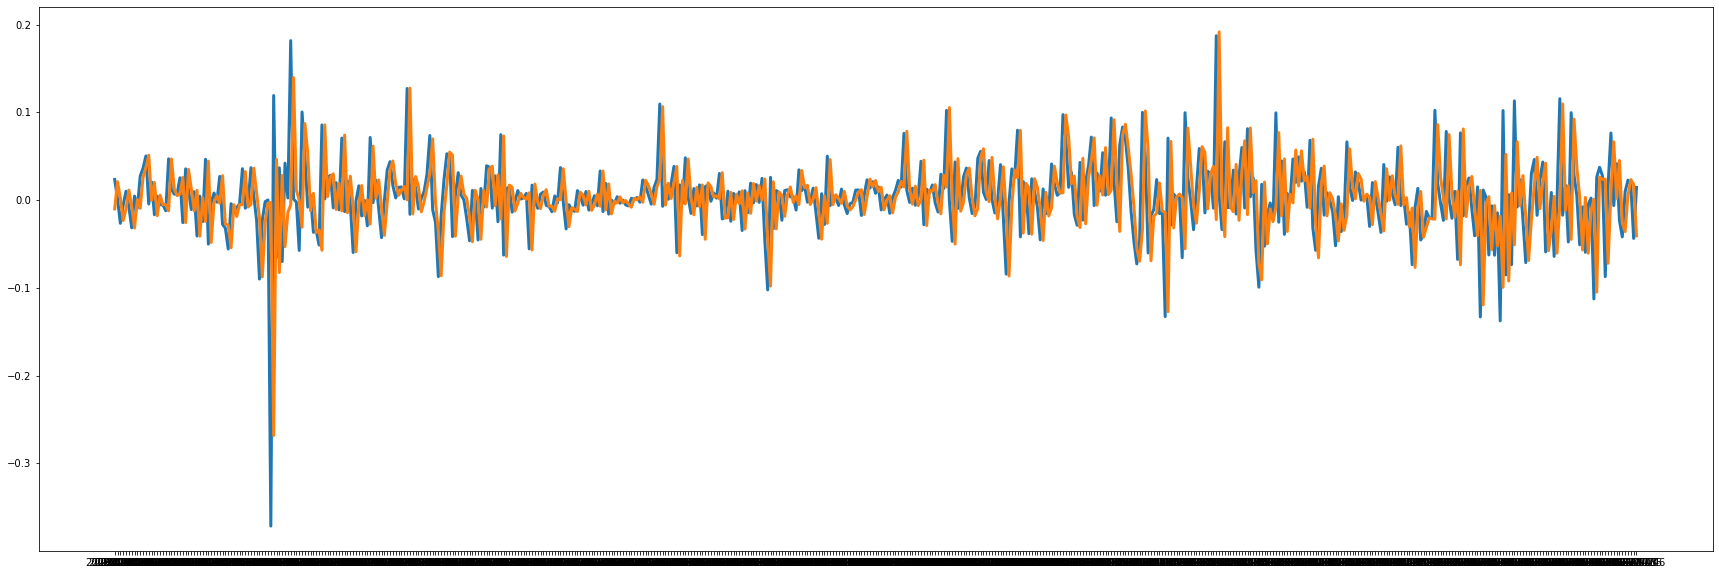

In [42]:
#Plotting real and predicted returns
plt.figure(figsize=(30, 10))
plt.plot(actual_returns,label='Actual',linewidth=3)
plt.plot(predicted_returns,label='prediction',linewidth=3)
plt.show()
         

### Converting BTC/MAD

### Importing USD/MAD Dataset and Merging

To convert Btc into MAD, we import a new Dataset 'USD_MAD - Dataset.csv' and then we merge it with our dataframe df 

In [43]:
#Importing and preprocessing
usdmad=pd.read_csv('USD_MAD - Dataset.csv')
usdmad=usdmad.sort_values('Date')
usdmad['Date'] = usdmad['Date'].apply(lambda x: x[-4:]+"-"+x[3:5]+"-"+x[0:2])
usdmad=usdmad.set_index('Date',drop=True)
for col in usdmad.columns[:-1]:
    usdmad[col]=usdmad[col].apply(lambda x: ".".join(x.split(",")))
usdmad['Variation %']=usdmad['Variation %'].apply(lambda x: (".".join(x.split(",")))[:-1])
usdmad

,Dernier,Ouv.,Plus Haut,Plus Bas,Variation %
Date,,,,,
2014-01-01,8.1748,8.1730,8.1805,8.1457,-0.05
2015-01-01,9.0640,9.0338,9.0710,9.0200,0.02
2016-01-01,9.8925,9.8873,9.8925,9.8680,-0.24
2018-01-01,9.3510,9.3510,9.3510,9.3510,0.00
2019-01-01,9.5569,9.5536,9.5790,9.5130,-0.01
...,...,...,...,...,...
2014-12-31,9.0621,9.0170,9.0955,8.9740,0.38
2015-12-31,9.9167,9.8467,9.9548,9.8430,0.40
2018-12-31,9.5583,9.5510,9.5783,9.5392,0.10


In [44]:
#merging
merged=df.join(usdmad)
merged['Dernier']=pd.to_numeric(merged['Dernier'])
merged['Ouv.']=pd.to_numeric(merged['Ouv.'])
merged['Plus Haut']=pd.to_numeric(merged['Plus Haut'])
merged['Plus Bas']=pd.to_numeric(merged['Plus Bas'])
merged['Variation %']=pd.to_numeric(merged['Variation %'])

In [45]:
#Filling NaN values with the 'backfill' approach
print(f"Before:\n\n{merged.isna().sum()}")
for col in usdmad.columns:
    merged[col].fillna(method='backfill',inplace=True)
print(f"\nAfter:\n\n{merged.isna().sum()}")

Before:

High             0
Low              0
Open             0
Close            0
Volume           0
Marketcap        0
Dernier        784
Ouv.           784
Plus Haut      784
Plus Bas       784
Variation %    784
dtype: int64

After:

High           0
Low            0
Open           0
Close          0
Volume         0
Marketcap      0
Dernier        0
Ouv.           0
Plus Haut      0
Plus Bas       0
Variation %    0
dtype: int64


In [46]:
merged.head()

,High,Low,Open,Close,Volume,Marketcap,Dernier,Ouv.,Plus Haut,Plus Bas,Variation %
Date,,,,,,,,,,,
2014-01-01,775.349976,754.969971,754.969971,771.400024,22489400.0,9.403308e+09,8.1748,8.1730,8.1805,8.1457,-0.05
2014-01-02,820.309998,767.210022,773.440002,802.390015,38489500.0,9.781074e+09,8.2151,8.1664,8.2391,8.1367,0.49
2014-01-03,834.150024,789.119995,802.849976,818.719971,37810100.0,9.980135e+09,8.2594,8.1787,8.2626,8.1704,0.54
2014-01-04,859.510010,801.669983,823.270020,859.510010,38005000.0,1.047736e+10,8.2369,8.2491,8.2686,8.1764,-0.27
2014-01-05,952.400024,854.520020,858.549988,933.530029,72898496.0,1.137966e+10,8.2369,8.2491,8.2686,8.1764,-0.27


In [47]:
#Converting BTC into MAD
def convert(date):
    s=merged.at[date,'Close']*merged.at[date,'Dernier']
    myformat="{0:.2f}"
    print(f"Un bitcoin valait le "+date+" "+str(myformat.format(s))+"dhs")
    
convert("2021-03-15")

Un bitcoin valait le 2021-03-15 502779.04dhs


## #Scraping

It is time to do some Scraping to select the real and recent price of BTC in MAD. To do this , we use selenium and Chrome driver

In [48]:
from selenium import webdriver
from selenium.webdriver.common.by import By
driver = webdriver.Chrome('./chromedriver')
driver.get("https://www.google.com/finance/quote/BTC-MAD")
Elts=driver.find_element_by_class_name("ln0Gqe")
Price=Elts.text.split()[:2]
p=''.join(Price)
l=p.split(",")
s=float(".".join(l))
print("The actual price of Bitcoin is ", s)

C:\Users\DELL\AppData\Local\Temp/ipykernel_23468/3942740300.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


The actual price of Bitcoin is  355036.37


C:\Users\DELL\AppData\Local\Temp/ipykernel_23468/3942740300.py:5: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  Elts=driver.find_element_by_class_name("ln0Gqe")


### Implementing the work strategy of the bot

In [49]:
pip install ta

In [50]:
#We have choosen the moving average of order 2 & 6 to describe the phenomenon 
import ta
df['SMA200'] = ta.trend.sma_indicator(df['Close'], 200)
df['SMA600'] = ta.trend.sma_indicator(df['Close'], 600)
print(df)

                    High           Low          Open         Close  \
Date                                                                 
2014-01-01    775.349976    754.969971    754.969971    771.400024   
2014-01-02    820.309998    767.210022    773.440002    802.390015   
2014-01-03    834.150024    789.119995    802.849976    818.719971   
2014-01-04    859.510010    801.669983    823.270020    859.510010   
2014-01-05    952.400024    854.520020    858.549988    933.530029   
...                  ...           ...           ...           ...   
2021-07-02  33939.588699  32770.680780  33549.600177  33897.048590   
2021-07-03  34909.259899  33402.696536  33854.421362  34668.548402   
2021-07-04  35937.567147  34396.477458  34665.564866  35287.779766   
2021-07-05  35284.344430  33213.661034  35284.344430  33746.002456   
2021-07-06  35038.536363  33599.916169  33723.509655  34235.193451   

                  Volume     Marketcap        SMA200        SMA600  
Date                

### <font color='red'>First strategy</font>

In [51]:
usd = 1000
bitcoin = 0
lastIndex = df.first_valid_index()
for index, row in df.iterrows():
  if df['SMA200'][lastIndex] > df['SMA600'][lastIndex] and usd > 10:
    bitcoin = usd / df['Close'][index] 
    bitcoin = bitcoin - 0.0007 * bitcoin
    usd = 0
    print("Buy BTC at",df['Close'][index],'$ the', index)

  if df['SMA200'][lastIndex] < df['SMA600'][lastIndex] and bitcoin > 0.0001:
    usd = bitcoin * df['Close'][index]
    usd = usd - 0.0007 * usd
    bitcoin = 0
    print("Sell Bitcoin at",df['Close'][index],'$ the', index)
  lastIndex = index



Buy BTC at 432.5190124511719 $ the 2016-02-27
Sell Bitcoin at 4017.26845712 $ the 2018-11-30
Buy BTC at 10407.965329 $ the 2019-08-23


In [52]:
finalResult = usd + bitcoin * df['Close'].iloc[-1]
print("Final result",finalResult,'USD')

Final result 30487.39121731203 USD


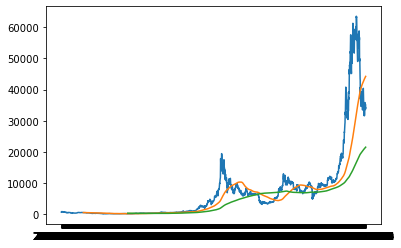

In [53]:
plt.plot(df['Close'])
plt.plot(df["SMA200"])
plt.plot(df["SMA600"])
plt.show()

### <font color='red'> Second Strategy</font>

In [54]:
mot= []  #Money over time
money = initial = 4000
mbtc = False # Money in bitcoin
growth = 1
threshold = 0.95      # we set a threshold value wich represents the price of the last day divided by the price predicted for tomowwor
                      # in order to make a profit from a transaction it should be smaller than 1 , but not too small because there can't be
                      # such a big change in price over one day , meaning it will never buy anything
    
    
for i in range(len(preds)-1) :
    money*=growth
    
    mot.append(money)
    
    if  ytest[i] / preds[i] < threshold:            # check whether the predicted price for tomorrow is smaller than the expected price for tomorrow 
        mbtc = True                 # if so , buy all the BTC you can
        growth = ytest[i+1] / ytest[i]
    else :                       
        mbtc = False                # otherwise we convert the BTC to money
        growth = 1 

Over the course of 537 days our 'trading bot' has $2169 and it started with $4000
A $-1830 difference , or -45.76% profit


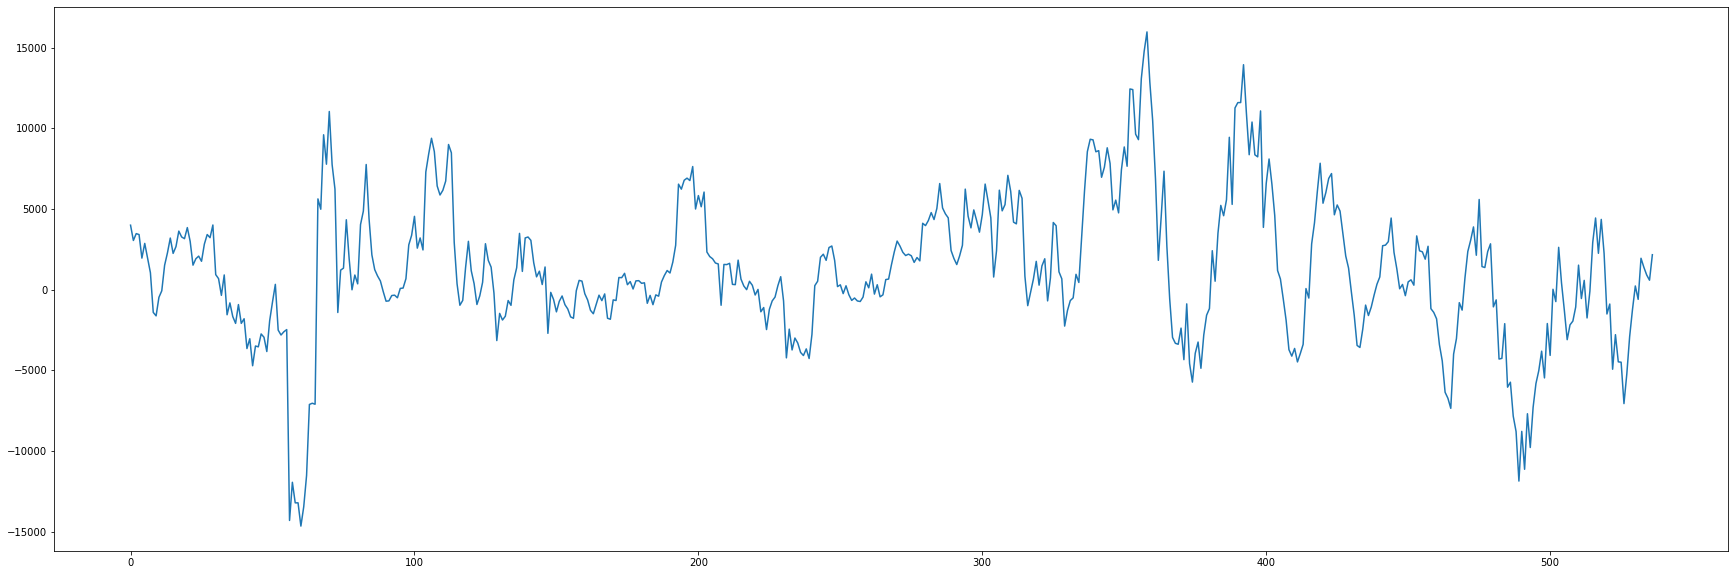

In [55]:
plt.figure(figsize=(30,10));
plt.plot(mot);
print(f"Over the course of {len(mot)} days our 'trading bot' has ${int(money)} and it started with ${initial}")
print(f"A ${int(money-initial)} difference , or {     '%.2f'%(money/initial*100 - 100)}% profit")

#### We can see that the second strategy isn't efficient because we risk to lose money if we adopt it, so we'll keep the first one   

## Thank you for your attention !